In [1]:
import time
import numpy as np
import pandas as pd
import json
import seaborn as sb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sb
import pickle
import re

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn import feature_selection

In [2]:
def qual_encode(qual):
    
    qual_list = ['Masters','MBA','PhD','J.D.']
    qual_encodings = {'Masters': 5, 'MBA': 5, 'PhD': 20, 'J.D.': 30}
    if qual in qual_list:
        return qual_encodings[qual]
    else:
        return 0
    
def get_exp(bio):
    
    if 'years' in bio:
        yrs = np.array([int(i) for i in re.findall('\d+', bio)])
        if len(yrs[yrs<50])>0:
            return max(yrs[yrs<50])
        else:
            return 0
    else:
        return 0
    
def get_exp_text(bio):
    
    numbers = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve',
          'thirteen','fourteen','fifteen','sixteen','seventeen','eighteen','nineteen','twenty','thirty',
          'forty','fifty']
    numbers_dict = {'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'nine':9,'ten':10,
                'eleven':11,'twelve':12, 'thirteen':13,'fourteen':14,'fifteen':15,'sixteen':16,'seventeen':17,
                'eighteen':18,'nineteen':19,'twenty':20,'thirty':30,'forty':40,'fifty':50}
    
    if any(x in bio.lower() for x in numbers):
        matches = [x for x in numbers if x in bio.lower()]
        return sum([numbers_dict[x] for x in matches])
    else:
        return 0

In [3]:
dbname = 'tutor_db'
username = 'codonnell'
pswd = '7883511'

con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM tutor_main
"""
tutor_data = pd.read_sql_query(sql_query,con)
tutor_data = tutor_data.drop_duplicates(subset='tut_id').reset_index(drop=True)
tutor_data['log_hourly_rate'] = np.log(tutor_data['hourly_rate'])
tutor_data['qual_encoded'] = tutor_data.apply(lambda x: qual_encode(x['qual_1']) + qual_encode(x['qual_2']), axis =1) 
tutor_data.head()

,index,description,hourly_rate,bio,background_check,tut_id,photo,rating_count,rating_av,review_count,...,sunday_hours,monday_hours,tuesday_hours,wednesday_hours,thursday_hours,friday_hours,saturday_hours,mean_hours,log_hourly_rate,qual_encoded
0,0,Fun Experienced Tutor!,60,"['Hi!', ""I'm an experienced tutor with a sense...",1,7269032,1,269,4.98885,15.0,...,0.583333,0.416667,0.583333,0.375000,0.375000,0.583333,0.583333,0.500000,4.094345,5
1,1,"Math, Writing and Econ Specialist, 8+ Years Tu...",75,"['From Algebra to MLA, Middle School to MBA, I...",1,7277990,1,338,4.93195,18.0,...,0.500000,0.541667,0.583333,0.583333,0.583333,0.500000,0.333333,0.517857,4.317488,5
2,2,Top-Rated Test Prep (SAT / ACT / ISEE / HSPT) ...,95,"[""I am an experienced (3000+ hours) tutor cert...",1,7611743,1,1046,4.94349,74.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.553877,0
3,3,Congratulations to my students entering Harvar...,95,['MARCH 2020: IN ORDER TO ASSIST MORE STUDENTS...,1,7614535,1,1602,4.97940,32.0,...,0.000000,0.375000,0.541667,0.541667,0.250000,0.416667,0.375000,0.357143,4.553877,5
4,13,"Patient, Knowledgeable and Effective Spanish T...",125,['I am a high school AP Spanish Language teach...,1,8022035,1,67,4.98507,12.0,...,0.041667,0.166667,0.083333,0.125000,0.125000,0.083333,0.000000,0.089286,4.828314,0


In [63]:
tutor_data.columns

Index(['index', 'description', 'hourly_rate', 'bio', 'background_check',
       'tut_id', 'photo', 'rating_count', 'rating_av', 'review_count',
       'bio_length', 'num_subjects', 'hours_tutoring', 'state', 'zip_code',
       'edu_length', 'inst_1', 'inst_2', 'inst_3', 'qual_1', 'qual_2',
       'qual_3', 'sunday_hours', 'monday_hours', 'tuesday_hours',
       'wednesday_hours', 'thursday_hours', 'friday_hours', 'saturday_hours',
       'mean_hours', 'log_hourly_rate', 'qual_encoded', 'all_ed', 'ivy_1e',
       'ivy_2e', 'ivy_3e', 'ivy_tot', 'state_1e', 'state_2e', 'state_3e',
       'state_tot', 'experience', 'exptext', 'exp_tot', 'ed_0', 'ed_1'],
      dtype='object')

In [4]:
ivys = 'Brown|Columbia|Dartmouth|Harvard|Cornell|Pennsylvania|Princeton|Yale'

In [5]:
tutor_data['all_ed'] = tutor_data['inst_1'] + ' ' + tutor_data['inst_2'] + ' ' + tutor_data['inst_3']

In [6]:
tutor_data['ivy_1e'] = tutor_data['inst_1'].str.contains(ivys).astype(int)
tutor_data['ivy_2e'] = tutor_data['inst_2'].str.contains(ivys).astype(int)
tutor_data['ivy_3e'] = tutor_data['inst_3'].str.contains(ivys).astype(int)
tutor_data['ivy_tot'] = tutor_data['ivy_1e']+tutor_data['ivy_2e']+tutor_data['ivy_3e']
#tutor_data['inst_1e'] = tutor_data['inst_1'].apply(ivy)
#tutor_data['inst_1e'] = tutor_data['inst_1'].apply(ivy)

In [7]:
tutor_data['state_1e'] = tutor_data['inst_1'].str.contains('State').astype(int)
tutor_data['state_2e'] = tutor_data['inst_2'].str.contains('State').astype(int)
tutor_data['state_3e'] = tutor_data['inst_3'].str.contains('State').astype(int)
tutor_data['state_tot'] = tutor_data['state_1e']+tutor_data['state_2e']+tutor_data['state_3e']
tutor_data['experience'] = tutor_data['bio'].apply(get_exp)
tutor_data['exptext'] = tutor_data['bio'].apply(get_exp_text)
tutor_data['exp_tot'] = tutor_data['experience'] + tutor_data['exptext']

In [8]:
#tutor_data = tutor_data[tutor_data['hours_tutoring']>10] 

In [9]:
stopWords = esw 

tfidf_ed = TfidfVectorizer(
    min_df = 0,
    max_df = 0.95,
    max_features = 20000,
    stop_words = stopWords,
    ngram_range = (1,2)
)
tfidf_ed.fit(tutor_data['all_ed'])
text_ed = tfidf_ed.transform(tutor_data['all_ed'])

In [8]:
loaded_model = pickle.load(open('model_xgb2.sav', 'rb'))
loaded_encodings = pickle.load(open('cbenc2.pkl', 'rb'))
tfidf_sub = pickle.load(open('tfidf.sav', 'rb'))
tfidf_ed = pickle.load(open('tfidf_ed.sav', 'rb'))
subPCA = pickle.load(open('subPCA.pkl', 'rb'))
edPCA = pickle.load(open('edPCA.pkl', 'rb'))

In [12]:
text_ed = tfidf_ed.transform(tutor_data['all_ed'])
ed_df = pd.DataFrame(edPCA.transform(text_ed.todense()))

In [10]:
stopWords = esw 

tfidf_bio = TfidfVectorizer(
    min_df = 0,
    max_df = 0.95,
    max_features = 20000,
    stop_words = stopWords,
    ngram_range = (1,2)
)
tfidf_bio.fit(tutor_data['bio'])
text_bio = tfidf_bio.transform(tutor_data['bio'])

KeyboardInterrupt: 

In [ ]:
ed_df1 = pd.DataFrame(PCA(n_components=2).fit_transform(text_ed[:10000].todense()))

In [11]:
edPCA = PCA(n_components=2).fit(text_ed[:10000].todense())

In [9]:
ed_df = pd.DataFrame(edPCA.transform(text_ed.todense()))

NameError: name 'text_ed' is not defined

In [11]:
ed_df2 = pd.DataFrame(PCA(n_components=2).fit_transform(text_ed[10000:].todense()))

In [12]:
bio_df1 = pd.DataFrame(PCA(n_components=5).fit_transform(text_bio[:8000].todense()))

In [13]:
bio_df2 = pd.DataFrame(PCA(n_components=5).fit_transform(text_bio[8000:].todense()))

In [21]:
#ed_df = pd.concat([ed_df1,ed_df2],ignore_index=True)
ed_df = ed_df.rename(columns={0 : 'ed_0', 1:'ed_1'})

In [14]:
ed_df

,ed_0,ed_1
0,-0.016402,-0.031496
1,0.669648,0.020776
2,-0.017695,-0.031896
3,-0.022501,-0.033860
4,-0.017356,-0.031909
...,...,...
15862,-0.019587,-0.039422
15863,-0.018527,-0.035644
15864,-0.009955,0.040209
15865,-0.015581,-0.029421


In [15]:
bio_df = pd.concat([bio_df1,bio_df2],ignore_index=True)
bio_df = bio_df.rename(columns={0 : 'bio_0', 1:'bio_1',2: 'bio_2',3:'bio_3',4:'bio_4'})

In [22]:
tutor_data['ed_0'] = ed_df['ed_0']
tutor_data['ed_1'] = ed_df['ed_1']
#tutor_data['bio_0'] = bio_df['bio_0']
#tutor_data['bio_1'] = bio_df['bio_1']
#tutor_data['bio_2'] = bio_df['bio_2']
#tutor_data['bio_3'] = bio_df['bio_3']
#tutor_data['bio_4'] = bio_df['bio_4']

In [13]:
sql_query = """
SELECT * FROM tutor_subjects
"""
tutor_subjects = pd.read_sql_query(sql_query,con)
tutor_subjects.head()

,index,tutor_ids,subjects
0,0,7269032,Precalculus
1,1,7269032,French
2,2,7269032,European History
3,3,7269032,Calculus
4,4,7269032,Spanish


In [14]:
tutors_joined = tutor_subjects.groupby('tutor_ids')['subjects'].apply(lambda x: ' '.join(x)).reset_index()
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(float)
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(int)

In [15]:
#all_features = ['qual_encoded','num_subjects','hours_tutoring','edu_length','sunday_hours',
#                'monday_hours','tuesday_hours','wednesday_hours','thursday_hours','friday_hours',
#                'saturday_hours','ivy_1e','ivy_2e','ivy_3e','hourly_rate','state_1e','state_2e',
#                'state_3e','experience',0,1,2,3,4,'log_hourly_rate']
cat_features = ['state','ivy_1e','ivy_2e','ivy_3e']
all_features = ['state','qual_encoded','num_subjects','hours_tutoring','edu_length',
                'rating_count','review_count','rating_av','bio_length',
                'sunday_hours','monday_hours','tuesday_hours','wednesday_hours','thursday_hours','friday_hours',
                'saturday_hours','ivy_1e','ivy_2e','ivy_3e','experience','hourly_rate','sub_0','sub_1','sub_2',
                'sub_3','sub_4','ed_0','ed_1','log_hourly_rate','exptext','exp_tot']
num_features = ['num_subjects','hours_tutoring','edu_length', 'rating_count', 'rating_av','review_count',
                'sunday_hours','monday_hours','tuesday_hours','wednesday_hours','thursday_hours','friday_hours',
                'saturday_hours','experience','bio_length','hourly_rate','sub_0','sub_1','sub_2',
                'sub_3','sub_4','ed_0','ed_1','exptext','exp_tot']

In [17]:
tfidf = pickle.load(open('tfidf.sav', 'rb'))
#tfidf.fit(tutors_joined['subjects'])
text_sub = tfidf.transform(tutors_joined['subjects'])
#subPCA = PCA(n_components=5).fit(text.todense())
subjects_df = pd.DataFrame(subPCA.transform(text_sub.todense()))

In [18]:
subjects_df = subjects_df.rename(columns={0 : 'sub_0', 1:'sub_1',2: 'sub_2',3:'sub_3',4:'sub_4'})

In [23]:
tdf = tutors_joined.join(subjects_df).drop_duplicates(subset='tutor_ids').reset_index(drop=True)
tutors_tfidf = pd.merge(tutor_data,tdf,left_on = 'tut_id',right_on = 'tutor_ids')[all_features]

In [24]:
tutors_outliers = tutors_tfidf[(tutors_tfidf['log_hourly_rate']<6) 
                               & (tutors_tfidf['log_hourly_rate']>2.5)]
                             # & (tutors_tfidf['state'])]
                    
tutors_outliers = tutors_outliers.drop('hourly_rate',axis=1)

In [29]:
tutors_outliers = tutors_tfidf[(tutors_tfidf['hourly_rate']<100) 
                               & (tutors_tfidf['hourly_rate']>=25)]
                             # & (tutors_tfidf['state'])]
                    
tutors_outliers = tutors_outliers.drop('log_hourly_rate',axis=1)
#tutors_outliers = tutors_outliers.drop('hourly_rate',axis=1)

In [26]:
cbenc = ce.CatBoostEncoder(cols=cat_features, random_state=1)
#encoded_data = tutors_outliers[num_features].join(tutors_outliers[cat_features].apply(encoder.fit_transform))

In [231]:
# Set up feature data and target data
X = tutors_outliers.drop(['log_hourly_rate',0,1], axis=1)

#X = poly.fit_transform(X)
y = tutors_outliers['log_hourly_rate']

X_new = feature_selection.SelectKBest(feature_selection.f_regression, k=10).fit_transform(X, y)

array([[1.000e+00, 5.000e+00, 8.390e+02, ..., 0.000e+00, 0.000e+00,
        1.500e+01],
       [1.000e+00, 3.100e+01, 9.620e+02, ..., 0.000e+00, 0.000e+00,
        9.000e+00],
       [0.000e+00, 7.200e+01, 3.899e+03, ..., 0.000e+00, 0.000e+00,
        3.000e+01],
       ...,
       [1.000e+00, 2.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        5.000e+00],
       [1.000e+00, 1.300e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 1.600e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        2.000e+01]])

In [27]:
poly = PolynomialFeatures(2)

# Set up feature data and target data
#X = tutors_outliers.drop('hourly_rate', axis=1)
X = tutors_outliers.drop('log_hourly_rate', axis=1)
#X = encoded_data.drop('hourly_rate', axis=1)

#X = poly.fit_transform(X)
#y = tutors_outliers['hourly_rate']
y = tutors_outliers['log_hourly_rate']
#y = encoded_data['hourly_rate']

# Initialise a balanced logisitic regression model
#model_base = XGBRegressor(n_estimators=400, learning_rate=0.01, random_state=1)
model_base = LinearRegression()

# Perform feature normalisation
scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop(['state','ivy_1e','ivy_2e','ivy_3e'],axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop(['state','ivy_1e','ivy_2e','ivy_3e'],axis=1)

#model_base.fit(train_X.values, train_y.values)
model_base.fit(train_X, train_y.values)

preds_val = model_base.predict(val_X)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)
print(model_base.score(val_X,val_y))

13.659082657864232
0.15508641233092213


Text(0, 0.5, 'Predicted Log Hourly Rate')

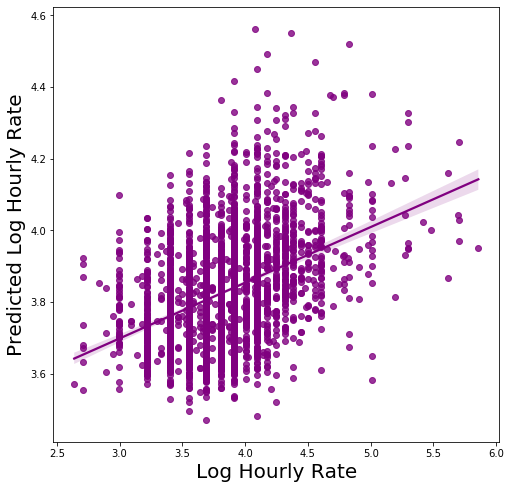

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
b = sb.regplot(val_y,preds_val, color='purple')
b.set_xlabel("Log Hourly Rate",fontsize=20)
b.set_ylabel("Predicted Log Hourly Rate",fontsize=20)

In [31]:
# Set up feature data and target data
#X = tutors_outliers.drop('hourly_rate', axis=1)
#X = encoded_data.drop('hourly_rate', axis=1)
X = tutors_outliers.drop('log_hourly_rate', axis=1)

#X = poly.fit_transform(X)
#y = encoded_data['hourly_rate']
#y = tutors_outliers['hourly_rate']
y = tutors_outliers['log_hourly_rate']

#model_base = Lasso(alpha=0.0004)
model_xgb = XGBRegressor(n_estimators=600, learning_rate=0.02, random_state=1)

# Perform feature normalisation
scaler = StandardScaler()


# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop(['state','ivy_1e','ivy_2e','ivy_3e'],axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop(['state','ivy_1e','ivy_2e','ivy_3e'],axis=1)

#model_base.fit(train_X.values, train_y.values)
model_xgb.fit(train_X.values, train_y.values)

preds_val = model_xgb.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

13.234854011993505


In [29]:
print(model_xgb.score(val_X,val_y))

0.20645427247118278


In [33]:
np.mean(np.abs((val_y - preds_val) / val_y)) * 100

6.663447766307118

Text(0, 0.5, 'Predicted Log Hourly Rate')

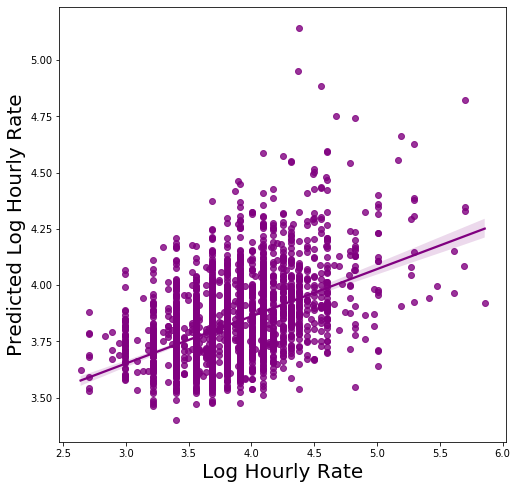

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
b = sb.regplot(val_y,preds_val, color='purple')
b.set_xlabel("Log Hourly Rate",fontsize=20)
b.set_ylabel("Predicted Log Hourly Rate",fontsize=20)

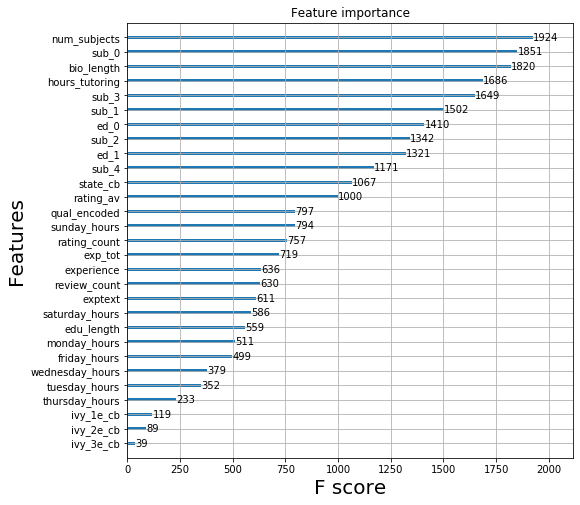

In [53]:
fig, ax = plt.subplots(figsize=(8, 8))

c = plot_importance(model_xgb,ax=ax)
c.set_xlabel("F score",fontsize=20)
c.set_ylabel("Features",fontsize=20)
plt.show()

In [72]:
val_X.columns

Index(['qual_encoded', 'num_subjects', 'hours_tutoring', 'edu_length',
       'rating_count', 'review_count', 'rating_av', 'bio_length',
       'sunday_hours', 'monday_hours', 'tuesday_hours', 'wednesday_hours',
       'thursday_hours', 'friday_hours', 'saturday_hours', 'experience',
       'sub_0', 'sub_1', 'sub_2', 'sub_3', 'sub_4', 'ed_0', 'ed_1', 'exptext',
       'exp_tot', 'state_cb', 'ivy_1e_cb', 'ivy_2e_cb', 'ivy_3e_cb'],
      dtype='object')

In [67]:
len(tutor_data[tutor_data['review_count']==0])

6561

/home/codonnell/anaconda3/envs/insight/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/codonnell/anaconda3/envs/insight/lib/python3.8/site-packages/seaborn/distributions.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return int(np.ceil((a.max() - a.min()) / h))


ValueError: cannot convert float NaN to integer

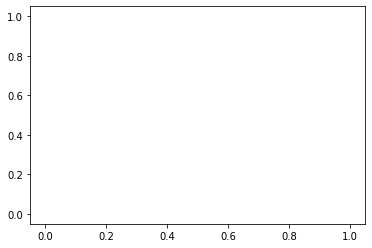

In [69]:
sb.distplot(np.log(tutor_data['hours_tutoring']))

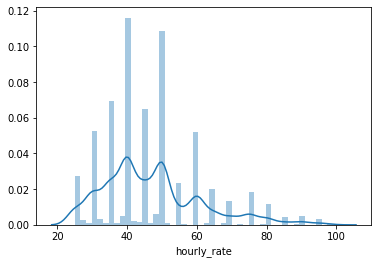

In [36]:
sb.distplot(tutors_outliers['hourly_rate'])

In [32]:
filename = 'model_xgb3.sav'
pickle.dump(model_xgb, open(filename, 'wb'))

In [55]:
#pickle.dump(edPCA.pkl)
pickle.dump(edPCA, open("edPCA.pkl", "wb" ))
pickle.dump(subPCA, open("subPCA.pkl", "wb" ))

In [56]:
pickle.dump(tfidf_ed, open("tfidf_ed.sav", "wb" ))

In [57]:
pickle.dump(tutors_outliers, open("tutors_outliers.pkl", "wb" ))

In [58]:
pickle.dump(cbenc, open("cbenc2.pkl", "wb"))

In [85]:
tutors_outliers.columns

Index([          'state',    'qual_encoded',    'num_subjects',
        'hours_tutoring',      'edu_length',    'sunday_hours',
          'monday_hours',   'tuesday_hours', 'wednesday_hours',
        'thursday_hours',    'friday_hours',  'saturday_hours',
                'ivy_1e',          'ivy_2e',          'ivy_3e',
            'experience',                 0,                 1,
                       2,                 3,                 4,
       'log_hourly_rate'],
      dtype='object')

In [250]:
len(val_y)

1626

In [147]:
test_data = tutor_data[(tutor_data['hourly_rate']<100) 
                               & (tutor_data['hourly_rate']>20)]

In [171]:
#edges = [20,30,40,50,60,70,80,90,100]
edges = [20,40,60,80,100]
bio_bins = []

for i in range(0,len(edges)-1):
    df = test_data[(test_data['hourly_rate']>=edges[i])& (test_data['hourly_rate']<edges[i+1])]
    bios = ' '.join(df['bio'])
    bio_bins.append(bios)

In [172]:
bio_df = pd.DataFrame({'interval':np.array(edges[1:]), 'bios': np.array(bio_bins)})

In [174]:
stopWords = esw 

tfidf = TfidfVectorizer(
    min_df = 0,
    max_df = 0.95,
    max_features = 20000,
    stop_words = stopWords,
    ngram_range = (1,2)
)
tfidf.fit(bio_df['bios'])
text = tfidf.transform(bio_df['bios'])

In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)

In [175]:
labels = tfidf.get_feature_names()

for i in range(0,len(edges)-1):
    
    print(','.join([labels[t] for t in np.argsort(np.array(text.todense()[i,:]))[0][-10:]]))

denver,little bit,military,english speakers,school love,korean,colombia,small groups,early childhood,substitute teacher
returned,facilitate,obtaining,university north,indiana,gis,small groups,english speakers,substitute teacher,early childhood
geometry pre,teaching esl,painting,mathematics education,relations,accent,provides,denver,doctoral,small groups
massachusetts institute,cooper,ian,stacy,wharton,martial arts,congratulations,stony,stony brook,brook


In [169]:
[labels[t] for t in np.argsort(np.array(text.todense()[0,:]))[0][-10:]]

['open',
 'substitute',
 'younger',
 'illustrator',
 'charlotte',
 'activities',
 'later',
 'lab',
 'teaching english',
 'special education']

In [61]:
bio1 =tutor_data[tutor_data['bio'].str.contains('years')]['bio'].iloc[0]
bio2 =tutor_data[~tutor_data['bio'].str.contains('years')]['bio'].iloc[3]

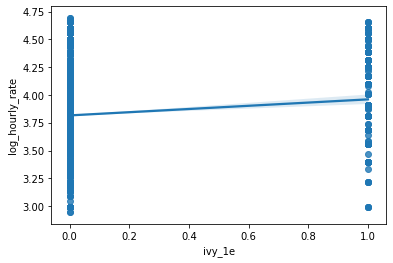

In [116]:
sb.regplot(tutors_outliers['ivy_1e'],tutors_outliers['log_hourly_rate'])

In [192]:
tutor_ca = pd.merge(tutor_data,tdf,left_on = 'tut_id',right_on = 'tutor_ids')
tutor_ca = tutor_ca[tutor_ca['state']=='CA'][all_features]
tutor_ca = tutor_ca.drop('hourly_rate',axis=1)
tutor_ca = tutor_ca[(tutor_ca['log_hourly_rate']<4.7) 
                               & (tutor_ca['log_hourly_rate']>2.9)]

In [195]:
X = tutor_ca.drop('log_hourly_rate', axis=1)

#X = poly.fit_transform(X)
y = tutor_ca['log_hourly_rate']

model_base = Lasso(alpha=0.003)
#model_base = XGBRegressor(n_estimators=500, learning_rate=0.01, random_state=1)

# Perform feature normalisation
scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(scaler.fit_transform(X), y, train_size=0.8, test_size=0.2, random_state = 1)

#model_base.fit(train_X.values, train_y.values)
model_base.fit(train_X, train_y.values)

preds_val = model_base.predict(val_X)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

13.413571189628287


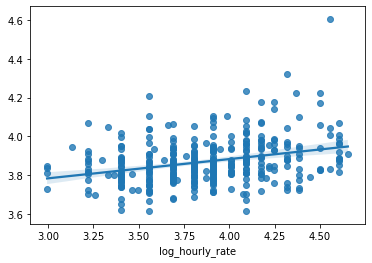

In [196]:
sb.regplot(val_y,preds_val)

In [198]:
tutor_data.groupby('state')['hourly_rate'].mean()

state
AL     70.000000
AZ     45.859813
CA     55.920901
CO     48.272727
CT    180.000000
DC     58.707692
DE     48.781250
FL     45.384546
GA     45.550725
IL     52.996473
IN     44.238095
KS     49.166667
KY     79.000000
MA    173.500000
MD     53.842857
MI     44.507246
MN     49.167832
MO     45.701031
NC     44.375887
NE     75.000000
NJ     57.391608
NM     39.179487
NV     41.857143
NY     72.618307
OH     46.823529
OK     15.000000
OR     42.500000
PA     48.549828
SC     75.230769
TN     47.306452
TX     47.542657
UT     42.718750
VA     47.888889
WA     52.807175
WI     12.000000
WV     35.000000
Name: hourly_rate, dtype: float64

In [108]:
old_model = pickle.load(open('/home/codonnell/Insight/astutor_flask/model_base.sav', 'rb'))
cbenc = pickle.load(open('/home/codonnell/Insight/astutor_flask/cb_encoding.sav', 'rb'))

In [119]:
cat_features =['state','qual_encoded']

In [124]:
# Set up feature data and target data
X = tutors_outliers[['state','qual_encoded', 'background_check',
                   'num_subjects','hours_tutoring','edu_length','mean_hours']]
y = tutors_outliers['log_hourly_rate']

# Initialise a balanced logisitic regression model
#model_base = XGBRegressor(n_estimators=400, learning_rate=0.01, random_state=1)
model_base = RandomForestRegressor(criterion = 'mae' , random_state=1)

# Perform feature normalisation
#scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

#cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop('state',axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop('state',axis=1)

model_base.fit(train_X.values, train_y.values)

preds_val = model_base.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))

KeyError: "['background_check', 'state', 'mean_hours'] not in index"

In [121]:
mae

16.45776408997905

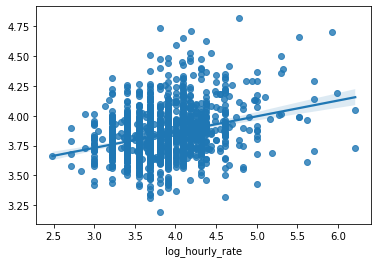

In [122]:
sb.regplot(val_y,preds_val)

In [55]:
test_str = 'a fshdslf !FIve six gjdfhs'
numbers = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve',
          'thirteen','fourteen','fifteen','sixteen','seventeen','eighteen','nineteen','twenty','thirty',
          'forty','fifty']
numbers_dict = {'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'nine':9,'ten':10,
                'eleven':11,'twelve':12, 'thirteen':13,'fourteen':14,'fifteen':15,'sixteen':16,'seventeen':17,
                'eighteen':18,'nineteen':19,'twenty':20,'thirty':30,'forty':40,'fifty':50}

if any(x in test_str for x in numbers):
    matches = [x for x in numbers if x in test_str]
    sum([numbers_dict[x] for x in matches])

In [58]:
get_exp_text(test_str)

11

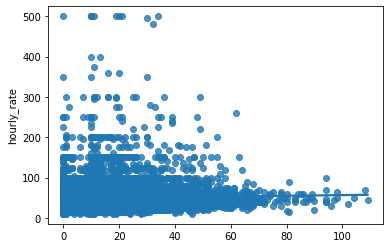

In [63]:
sb.regplot(tutor_data['exptext']+tutor_data['experience'],tutor_data['hourly_rate'])